In [6]:
# numpy and pandas for data manipulation
import sys
# Suppress warnings
import warnings
import seaborn as sns
import matplotlib as plt
import networkx as nx
import numpy as np
import matplotlib.ticker as ticker
import pandas as pd
import os
import matplotlib2tikz
plt.style.use('seaborn')
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=4, rc={"lines.markersize": 15})
plt.rc('hatch', color='white', linewidth=1)
plt.rcParams.update({
    "font.family": "serif",
     "font.serif": [] ,
      "font.sans-serif": ["Linux Biolinum"]  })

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
ROOT_RESULT_FOLDER = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/experiment_results/remote'


SYSTEM_COLOR = sns.color_palette()[0]
ALL_MAT_COLOR = sns.color_palette()[1]
ALL_COMPUTE_COLOR = sns.color_palette()[2]
BOTTOMUP_COLOR = sns.color_palette()[3]

WRITE_DIRECTORY_ROOT = \
'/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/papers/images/experiment-results'

output_directory = WRITE_DIRECTORY_ROOT + '/kaggle_home_credit/reuse'
def create_folder(path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise

In [7]:
result_folder = ROOT_RESULT_FOLDER + '/reuse/kaggle_home_credit'
result_file = result_folder + '/cloud-41/2019-10-13/23-13.csv'

In [8]:
HEADERS = [
    'timestamp', 'exp_id', 'repo', 'workload', 'mat_type','reuse_type', 'budget','run_time'
]
execution_order = {
    'start_here_a_gentle_introduction': 1,
    'introduction_to_manual_feature_engineering': 2,
    'introduction_to_manual_feature_engineering_p2': 3,
    'fork_cridata_start_here_a_gentle_introduction': 4,
    'fork_taozhongxiao_start_here_a_gentle_introduction': 5,
    'fork_introduction_to_manual_feature_engineering': 6,
    'fork_introduction_to_manual_feature_engineering_p2': 7,
    'fork_join_start_here_intro': 8
}
reuse_map = {'linear':'LN','all_mat':'ALL_M', 'all_compute':'ALL_C', 'bottomup':'BU'}
reuse_result = pd.read_csv(result_file, header=None, names=HEADERS)
reuse_result['workload_order'] = reuse_result['workload'].replace(execution_order)
reuse_result['reuse_type'] = reuse_result['reuse_type'].replace(reuse_map)
reuse_result = reuse_result[reuse_result.reuse_type != 'BU']
reuse_result['cumulative_run_time'] = reuse_result.groupby(['exp_id', 'reuse_type'])['run_time'].apply(lambda x: x.cumsum())

In [19]:
def plot_executions_times(df, loc=None):
    plt.figure(figsize=(7,4))
    plot = sns.lineplot(
        data=df,
        x='workload_order',
        y='cumulative_run_time',
        hue='reuse_type',
        style='reuse_type',
        markers={
            'LN': "o",
            'ALL_M': "^",
            'ALL_C': 'v'
        },
        lw=3,
        hue_order=['LN', 'ALL_M', 'ALL_C'],
       # style_order = ['baseline', 'optimized'],
        dashes={
            'LN': (1, 0),
            'ALL_M': (1, 1),
            'ALL_C': (2, 1)
        },
        palette={
            'LN': SYSTEM_COLOR,
            'ALL_M': ALL_MAT_COLOR,
            'ALL_C': ALL_COMPUTE_COLOR
        },
        legend='brief')
    lg = plt.legend(
        loc='upper center',
        handlelength=1.5,
        handletextpad=0.1,
        fontsize=28,
        ncol=3,
        columnspacing=0.5,
        bbox_to_anchor=(0.55, 1.2))
    handles = lg.legendHandles
    labels = ['LN', 'ALL_M', 'ALL_C']
    del handles[0]
    from matplotlib.lines import Line2D
    handles[0] = Line2D([0], [1],
                        color=SYSTEM_COLOR,
                        linewidth=4,
                        dashes=(1, 0),
                        marker="o")
    handles[1] = Line2D([0], [1],
                        color=ALL_MAT_COLOR,
                        linewidth=4,
                        dashes=(1, 1),
                        marker="^")
    handles[2] = Line2D([0], [1],
                        color=ALL_COMPUTE_COLOR,
                        linewidth=4,
                        dashes=(2, 1),
                        marker="v")
    legend = plt.legend(
        handles,
        labels,
        loc='upper center',
        handlelength=1.5,
        handletextpad=0.1,
        fontsize=32,
        numpoints=1,
        ncol=3,
        columnspacing=0.5,
        bbox_to_anchor=(0.5, 1.3))

    
    for line in legend.get_lines():
        line.set_linewidth(4.0)
    plot.set_xlabel('Workload', fontsize=30)
    plot.set_ylabel('Cumulative Run Time (s)', fontsize=30)
    #plot.set_xlim((1,2))
    plot.set_ylim((0,2200))
    plot.set_yticks([0, 500, 1000, 1500, 2000])
    plot.set_xticks(range(1,9))
    plot.set_xticklabels(range(1,9))
    plot.yaxis.set_major_formatter(ticker.EngFormatter(sep=''))
    #plt.tight_layout()
    if loc is not None:
        plt.savefig(loc, bbox_inches ='tight')

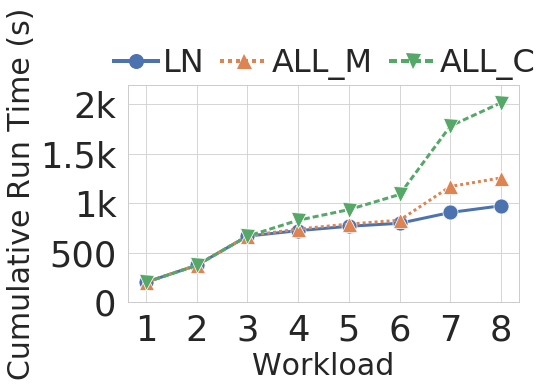

In [21]:
df = reuse_result[reuse_result.mat_type == 'simple']
#plot_executions_times(df)
plot_executions_times(df, output_directory+'/simple-mat.pgf')

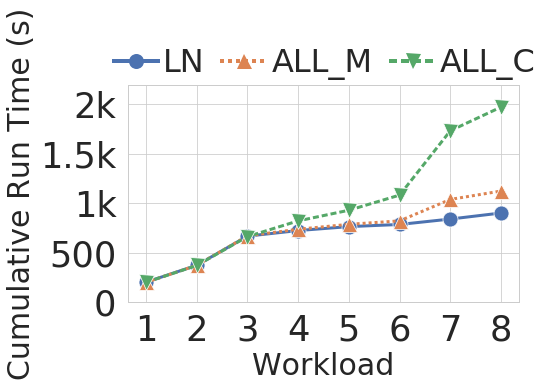

In [22]:
df = reuse_result[reuse_result.mat_type == 'storage_aware']
#plot_executions_times(df)
plot_executions_times(df, output_directory+'/storage-aware-mat.pgf')